# Git Repository Bringup

In [3]:
!git version

git version 2.34.1


In [4]:
!git clone https://github.com/ramwtz/data-science-project.git

Cloning into 'data-science-project'...
remote: Enumerating objects: 88, done.
remote: Counting objects: 100% (88/88), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 88 (delta 30), reused 46 (delta 12), pack-reused 0
Receiving objects: 100% (88/88), 16.36 MiB | 7.80 MiB/s, done.
Resolving deltas: 100% (30/30), done.


In [5]:
!ls

data-science-project  sample_data


In [6]:
%cd data-science-project/

/content/data-science-project


In [7]:
!pwd

/content/data-science-project


In [8]:
!git switch dev/ram

Branch 'dev/ram' set up to track remote branch 'dev/ram' from 'origin'.
Switched to a new branch 'dev/ram'


In [9]:
%cd ..

/content


# Basic Bringup for Remote Envrionment

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
# Necessary packages for this nb
!pip install --quiet -r '/content/data-science-project/dependencies.txt'
!pip install --upgrade scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 794.3/794.3 kB 46.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 74.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 74.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 72.9 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


# Initialize Env

In [12]:
# Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import librosa as lbrs
import IPython
import IPython.display as ipd
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers, optimizers, callbacks
from sklearn import metrics
from scipy import fft
from tensorflow.keras.utils import plot_model

# Configs
%load_ext autotime
tqdm.pandas()

time: 855 µs (started: 2023-09-26 15:51:25 +00:00)


In [13]:
gen_data_dir = os.path.join('drive', 'MyDrive', 'project', 'data')
calls_dir = os.path.join(gen_data_dir, 'calls')
new_data_dir = os.path.join(gen_data_dir, 'new')

#
metadata_path = os.path.join(calls_dir, '911_first6sec', '911_metadata_6sec.csv')

time: 1.04 ms (started: 2023-09-26 15:51:25 +00:00)


In [14]:
def get_path_from_filename(audio_file_name):
    type_dir, file_name = audio_file_name.split('/')
    return os.path.join(calls_dir, type_dir, file_name)

time: 455 µs (started: 2023-09-26 15:51:25 +00:00)


In [15]:
def create_audio_series(audio_file_name):
    audio_file_path = get_path_from_filename(audio_file_name)
    data, sample_rate = lbrs.load(audio_file_path)
    return data, sample_rate

time: 683 µs (started: 2023-09-26 15:51:25 +00:00)


# Create Metadata Dataframe

In [16]:
# load metadata from csv to a pandas dataframe
metadata_df = pd.read_csv(metadata_path)

time: 6.55 s (started: 2023-09-26 15:51:25 +00:00)


In [17]:
print(metadata_df.count())

id                 710
event_id           710
link               710
title              710
date               689
state              702
deaths             709
potential_death    709
false_alarm        709
description        701
deaths_binary      710
break              710
filename           710
dtype: int64
time: 18.2 ms (started: 2023-09-26 15:51:32 +00:00)


In [18]:
# TODO (ram): need to find the duplicates
metadata_df.drop_duplicates(subset=['filename'], inplace=True)
metadata_df.reset_index(drop=True, inplace=True)
print(metadata_df.count())

id                 707
event_id           707
link               707
title              707
date               686
state              699
deaths             706
potential_death    706
false_alarm        706
description        699
deaths_binary      707
break              707
filename           707
dtype: int64
time: 15.5 ms (started: 2023-09-26 15:51:32 +00:00)


In [19]:
metadata_df[metadata_df['deaths'].isnull()]

,id,event_id,link,title,date,state,deaths,potential_death,false_alarm,description,deaths_binary,break,filename
39,39,54,https://web.archive.org/web/20150417085342/htt...,Boat rescue #1 – Minn.,NaN,NaN,NaN,NaN,NaN,NaN,0,2.0,911_first6sec/call_54_0.wav


time: 26.4 ms (started: 2023-09-26 15:51:32 +00:00)


In [20]:
# TODO (Ram): maybe we can tag this ourselves
metadata_df = metadata_df[metadata_df['deaths'].notna()]
metadata_df.reset_index(drop=True, inplace=True)
print(metadata_df.count())

id                 706
event_id           706
link               706
title              706
date               686
state              699
deaths             706
potential_death    706
false_alarm        706
description        699
deaths_binary      706
break              706
filename           706
dtype: int64
time: 9.57 ms (started: 2023-09-26 15:51:32 +00:00)


# MFCC Model - Introduction
We will begin our attempts with models using Mel-frequency cepstral coefficients (MFCCs) as features, using as a reference [this paper](https://ietresearch.onlinelibrary.wiley.com/doi/full/10.1049/tje2.12082) on speech recognition by Rakibul Hasan, Mahbub Hasan & Zakir Hossain, although speech recognition is not the intent, the model we are attempting to build is tangentialially related, and so this is a good reference point to start from.

The following method will be applied to a data frame,
receiving number of mfcc featuresm and additionally window size and hop length if needed.

In [ ]:
#Setup


In [21]:
def mfcc_feature_extractor(filename, n_mfcc=13, n_fft=512, hop_length=124):
  data, sr = create_audio_series(filename)
  mfcc = lbrs.feature.mfcc(
      y=data, sr=sr, n_mfcc=n_mfcc,
      n_fft=n_fft, hop_length=hop_length
      )

  return np.mean(mfcc.T, axis=0)

time: 769 µs (started: 2023-09-26 15:51:48 +00:00)


The following function is a 'modular' model creation method that allows us versitility with our on the fly model creations:

In [22]:
def create_model(input_shape, hidden_layers, unit_scalar=3,
                 optimizer_name='Adam', learning_rate=0.0005,
                 activation='tanh'):
  if unit_scalar < 0:
    raise AttributeError("unit_scalar must be non-negative")

  # create model & input layer, with the number of input layers
  # equal to the number of features per sample
  model = models.Sequential()
  model._name = f'model_{hidden_layers}hl_{input_shape[0]}mfcc'
  model.add(layers.InputLayer(input_shape=input_shape))

  # add hidden layers dynamically
  for i in range(hidden_layers):
    units = 2 ** (hidden_layers + unit_scalar - i)
    lyr = layers.Dense(units=units, activation=activation)
    lyr._name = f'hidden_layer_{i+1}'
    model.add(lyr)

  # out put layer of size 2 as the number of classes
  out_lyr = layers.Dense(units=2, activation='softmax')
  out_lyr._name = 'output_layer'
  model.add(out_lyr)

  # TODO add optimizer scheduler?
  # https://keras.io/api/optimizers/

  # add optimizer and compile model
  opt = getattr(optimizers, optimizer_name)
  model.compile(
    loss='sparse_categorical_crossentropy',
    # TODO other metrics?
    metrics=['accuracy'],
    optimizer=opt(learning_rate))

  return model

time: 7.55 ms (started: 2023-09-26 15:51:48 +00:00)


# MFCC Model - Large Model
We will begin with what the aforementioned paper referenced as higher performing models, specifically a model using 25 MFCC features, and 4 hidden layers

## Extracting Features and Classes

### The Models' features
MFCCs are essentialy an extension of the STFT that we've seen in the previous section, in that the MFCCs are computed by breaking up the signal into windows and computing the DFT for each window, but expands upon this by mapping the signal to the mel-scale, taking the log of mapping and applying a discrete cosine transform, with the MFCC being the magnitude of the resulting spectrum.

In [23]:
# paths
filenames = metadata_df['filename']
features = filenames.progress_apply(mfcc_feature_extractor, n_mfcc=25)
features.rename('features', inplace=True)

features_named = pd.concat([filenames, features], axis=1)
features_named.head(10)

100%|██████████| 706/706 [10:10<00:00,  1.16it/s]


,filename,features
0,911_first6sec/call_2_0.wav,"[-496.04065, 136.32658, -38.824547, -2.956653,..."
1,911_first6sec/call_8_0.wav,"[-542.26483, 113.492096, -54.898445, -16.93544..."
2,911_first6sec/call_9_0.wav,"[-469.10492, 144.50133, -53.16924, -35.66156, ..."
3,911_first6sec/call_10_0.wav,"[-461.7921, 102.00011, 4.2778754, -3.2980382, ..."
4,911_first6sec/call_11_0.wav,"[-388.4136, 191.76454, -68.483246, -28.393341,..."
5,911_first6sec/call_12_0.wav,"[-366.632, 123.76255, -8.727576, -9.830455, 2...."
6,911_first6sec/call_13_0.wav,"[-328.94275, 173.40773, -122.68931, -22.340195..."
7,911_first6sec/call_15_0.wav,"[-388.2811, 92.171074, 0.91390646, -14.596169,..."
8,911_first6sec/call_16_0.wav,"[-500.0724, 121.41379, -37.134045, 13.093015, ..."
9,911_first6sec/call_17_0.wav,"[-335.3681, 180.51752, -75.116455, -6.7831354,..."


time: 10min 10s (started: 2023-09-26 15:51:51 +00:00)


In [24]:
print(f'Number of samples: {len(features)}')
print(f'Number of MFCCs per sample: {len(features[0])}')

Number of samples: 706
Number of MFCCs per sample: 25
time: 1.21 ms (started: 2023-09-26 16:02:01 +00:00)


 ### The Models' Classes

In [25]:
# Create classification
classes_named = metadata_df[['filename', 'deaths_binary']]

classes_named = classes_named.rename(
  columns={'deaths_binary': 'resulted_in_deaths'})

# Create combied dataframe
features_classes = pd.merge(features_named, classes_named)
features_classes.head(10)

,filename,features,resulted_in_deaths
0,911_first6sec/call_2_0.wav,"[-496.04065, 136.32658, -38.824547, -2.956653,...",1
1,911_first6sec/call_8_0.wav,"[-542.26483, 113.492096, -54.898445, -16.93544...",1
2,911_first6sec/call_9_0.wav,"[-469.10492, 144.50133, -53.16924, -35.66156, ...",0
3,911_first6sec/call_10_0.wav,"[-461.7921, 102.00011, 4.2778754, -3.2980382, ...",1
4,911_first6sec/call_11_0.wav,"[-388.4136, 191.76454, -68.483246, -28.393341,...",0
5,911_first6sec/call_12_0.wav,"[-366.632, 123.76255, -8.727576, -9.830455, 2....",1
6,911_first6sec/call_13_0.wav,"[-328.94275, 173.40773, -122.68931, -22.340195...",1
7,911_first6sec/call_15_0.wav,"[-388.2811, 92.171074, 0.91390646, -14.596169,...",1
8,911_first6sec/call_16_0.wav,"[-500.0724, 121.41379, -37.134045, 13.093015, ...",1
9,911_first6sec/call_17_0.wav,"[-335.3681, 180.51752, -75.116455, -6.7831354,...",1


time: 55.1 ms (started: 2023-09-26 16:02:01 +00:00)


In [26]:
# save to csv in new data directory
features_classes_path = os.path.join(new_data_dir, 'features_classes.csv')
features_classes.to_csv(features_classes_path, encoding='utf-8', index=False)

time: 1.19 s (started: 2023-09-26 16:02:01 +00:00)


### Creating Training and Testing Sets

In [27]:
features = np.array(features_classes['features'].tolist())
classes = np.array(features_classes['resulted_in_deaths'])

time: 2.36 ms (started: 2023-09-26 16:02:02 +00:00)


In [28]:
print(classes.shape)

(706,)
time: 1.88 ms (started: 2023-09-26 16:02:02 +00:00)


In [29]:
print(features.shape)

(706, 25)
time: 579 µs (started: 2023-09-26 16:02:02 +00:00)


In [30]:
X_train_large_model, X_test_large_model, y_train_large_model, y_test_large_model = train_test_split(
    features, classes ,test_size=0.25, shuffle=True, stratify=classes,
    random_state=0
    )

time: 7.25 ms (started: 2023-09-26 16:02:02 +00:00)


## Defining and Training the Model

In [31]:
input_shape = (features.shape[1],)
hidden_layers = 4
unit_scalar = 3

large_model = create_model(
    input_shape=input_shape, hidden_layers=hidden_layers,
    unit_scalar=unit_scalar)

print(large_model.summary())

Model: "model_4hl_25mfcc"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)      (None, 128)               3328      
                                                                 
 hidden_layer_2 (Dense)      (None, 64)                8256      
                                                                 
 hidden_layer_3 (Dense)      (None, 32)                2080      
                                                                 
 hidden_layer_4 (Dense)      (None, 16)                528       
                                                                 
 output_layer (Dense)        (None, 2)                 34        
                                                                 
Total params: 14226 (55.57 KB)
Trainable params: 14226 (55.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
time: 331

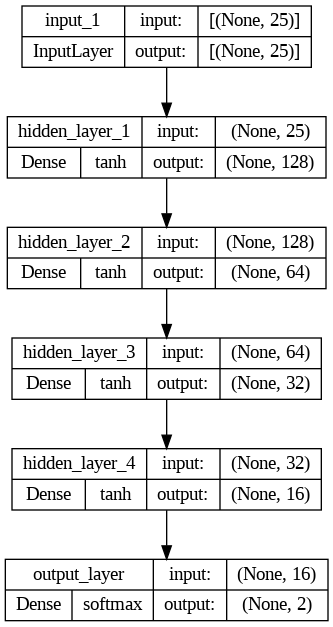

time: 152 ms (started: 2023-09-26 16:02:03 +00:00)


In [32]:
plot_model(large_model, show_shapes=True, show_layer_activations=True)

In [33]:
# define callbacks
reduce_lr_callback = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=10, min_lr=0.000005, verbose=1)

time: 592 µs (started: 2023-09-26 16:02:03 +00:00)


In [34]:
epochs = 500

large_fit  = large_model.fit(
    X_train_large_model,
    y_train_large_model,
    epochs=epochs,
    validation_data=(X_test_large_model, y_test_large_model),
    callbacks=[reduce_lr_callback],
    verbose=0)
print()


Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 21: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 31: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 41: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 51: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 61: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 71: ReduceLROnPlateau reducing learning rate to 5e-06.

time: 1min 23s (started: 2023-09-26 16:02:03 +00:00)


## Assessing the Model

In [35]:
large_fit_history = pd.DataFrame(large_fit.history)
model_architecture = f'{features.shape[1]} MFCCs & {hidden_layers} Hidden Layers'
print(f'Number of Actual Epochs: {large_fit_history.shape[0]}')

Number of Actual Epochs: 500
time: 4.23 ms (started: 2023-09-26 16:03:26 +00:00)


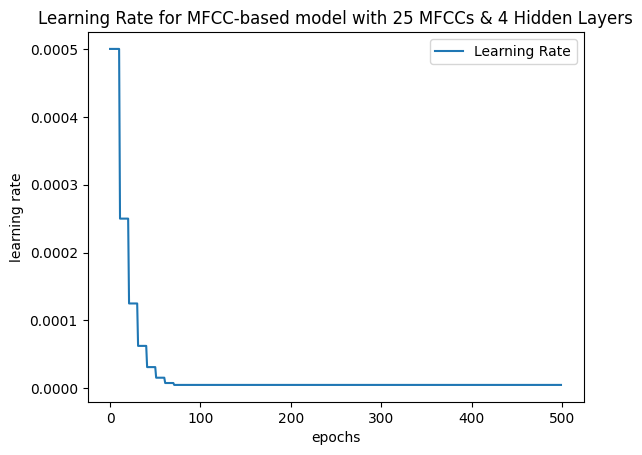

time: 381 ms (started: 2023-09-26 16:03:26 +00:00)


In [36]:
learning_rate_history = large_fit_history[['lr']]
learning_rate_title = f'Learning Rate for MFCC-based model with {model_architecture}'
learning_rate_history = learning_rate_history.rename(
    columns={'lr': 'Learning Rate'})
learning_rate_history.plot(
    title=learning_rate_title, xlabel='epochs', ylabel='learning rate')
plt.show()

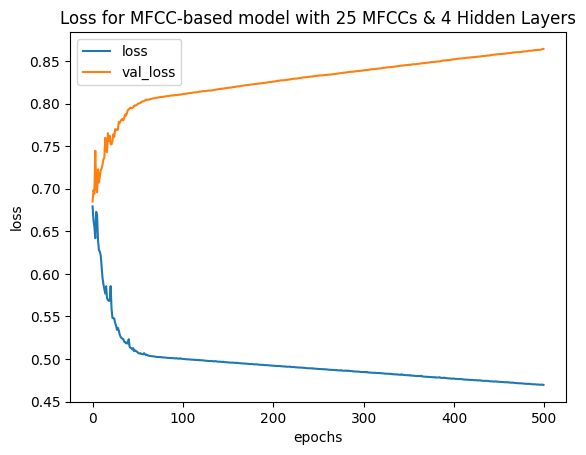

time: 279 ms (started: 2023-09-26 16:03:27 +00:00)


In [37]:
loss_history_title = f'Loss for MFCC-based model with {model_architecture}'
loss_history = large_fit_history[['loss','val_loss']]
loss_history.plot(title=loss_history_title, xlabel='epochs', ylabel='loss')
plt.show()

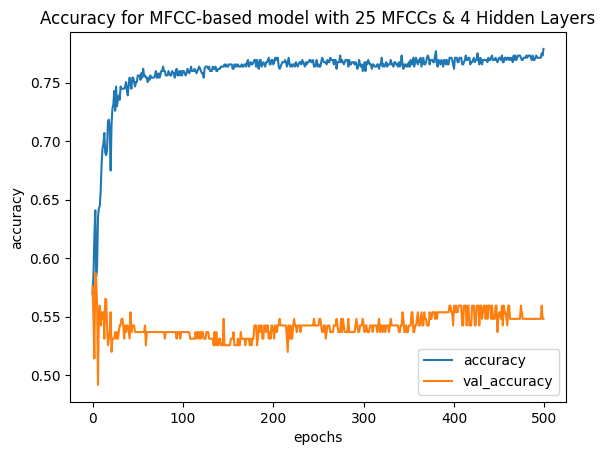

time: 294 ms (started: 2023-09-26 16:03:27 +00:00)


In [38]:
accuracy_history_title = f'Accuracy for MFCC-based model with {model_architecture}'
accuracy_history = large_fit_history[['accuracy','val_accuracy']]
accuracy_history.plot(
    title=accuracy_history_title, xlabel='epochs', ylabel='accuracy')
plt.show()

In [39]:
large_model_accuracy = large_model.evaluate(X_test_large_model,
  y_test_large_model, verbose=0)
print(large_model_accuracy)

[0.8643737435340881, 0.5480226278305054]
time: 106 ms (started: 2023-09-26 16:03:27 +00:00)


In [40]:
large_model_y_probability = large_model.predict(X_test_large_model, verbose=0)
large_model_y_predicted = np.argmax(large_model_y_probability, axis=-1)

time: 230 ms (started: 2023-09-26 16:03:27 +00:00)


In [84]:
large_model_report = metrics.classification_report(
    y_test_large_model, large_model_y_predicted, digits=4,
    target_names=['Non-Fatal','Fatal'])
print(large_model_report)

              precision    recall  f1-score   support

   Non-Fatal     0.4375    0.3889    0.4118        72
       Fatal     0.6106    0.6571    0.6330       105

    accuracy                         0.5480       177
   macro avg     0.5241    0.5230    0.5224       177
weighted avg     0.5402    0.5480    0.5430       177

time: 17.3 ms (started: 2023-09-26 16:19:28 +00:00)


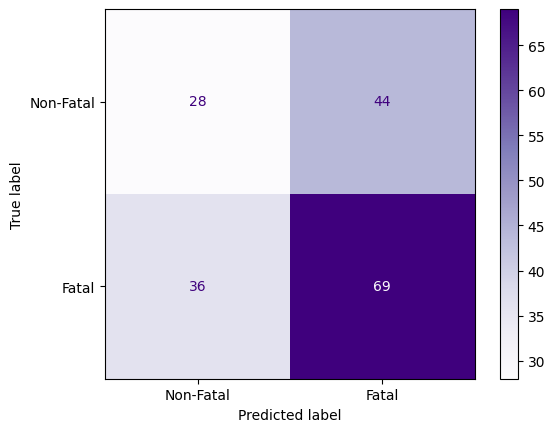

time: 269 ms (started: 2023-09-26 16:03:28 +00:00)


In [42]:
metrics.ConfusionMatrixDisplay.from_predictions(
    y_test_large_model, large_model_y_predicted,
    display_labels=['Non-Fatal','Fatal'],
    cmap='Purples')
plt.show()

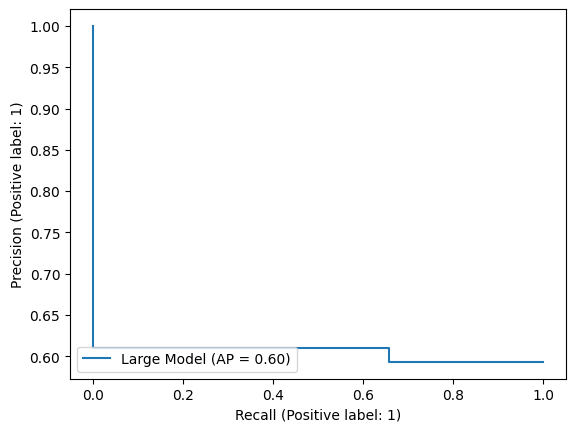

time: 277 ms (started: 2023-09-26 16:03:28 +00:00)


In [43]:
metrics.PrecisionRecallDisplay.from_predictions(
    y_test_large_model, large_model_y_predicted, name='Large Model')
plt.show()

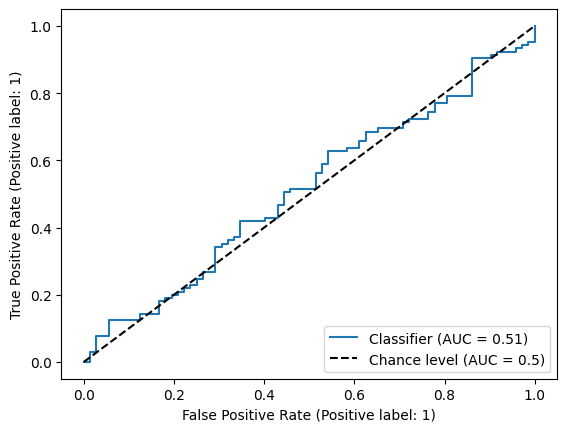

time: 280 ms (started: 2023-09-26 16:03:28 +00:00)


In [44]:
metrics.RocCurveDisplay.from_predictions(
    y_test_large_model, large_model_y_probability[:, 1], plot_chance_level=True)
plt.show()

# MFCC Model - Small Model

## Extracting Features and Classes

### The Models' features

In [50]:
# paths
filenames = metadata_df['filename']
features = filenames.progress_apply(mfcc_feature_extractor, n_mfcc=13)
features.rename('features', inplace=True)

features_named = pd.concat([filenames, features], axis=1)
features_named.head(10)

100%|██████████| 706/706 [00:32<00:00, 21.49it/s]


,filename,features
0,911_first6sec/call_2_0.wav,"[-496.04065, 136.32658, -38.824547, -2.956653,..."
1,911_first6sec/call_8_0.wav,"[-542.26483, 113.492096, -54.898445, -16.93544..."
2,911_first6sec/call_9_0.wav,"[-469.10492, 144.50133, -53.16924, -35.66156, ..."
3,911_first6sec/call_10_0.wav,"[-461.7921, 102.00011, 4.2778754, -3.2980382, ..."
4,911_first6sec/call_11_0.wav,"[-388.4136, 191.76454, -68.483246, -28.393341,..."
5,911_first6sec/call_12_0.wav,"[-366.632, 123.76255, -8.727576, -9.830455, 2...."
6,911_first6sec/call_13_0.wav,"[-328.94275, 173.40773, -122.68931, -22.340195..."
7,911_first6sec/call_15_0.wav,"[-388.2811, 92.171074, 0.91390646, -14.596169,..."
8,911_first6sec/call_16_0.wav,"[-500.0724, 121.41379, -37.134045, 13.093015, ..."
9,911_first6sec/call_17_0.wav,"[-335.3681, 180.51752, -75.116455, -6.7831354,..."


time: 32.9 s (started: 2023-09-26 16:08:32 +00:00)


In [51]:
print(f'Number of samples: {len(features)}')
print(f'Number of MFCCs per sample: {len(features[0])}')

Number of samples: 706
Number of MFCCs per sample: 13
time: 4.54 ms (started: 2023-09-26 16:09:05 +00:00)


 ### The Models' Classes

In [52]:
# Create classification
classes_named = metadata_df[['filename', 'deaths_binary']]

classes_named = classes_named.rename(
  columns={'deaths_binary': 'resulted_in_deaths'})

# Create combied dataframe
features_classes = pd.merge(features_named, classes_named)
features_classes.head(10)

,filename,features,resulted_in_deaths
0,911_first6sec/call_2_0.wav,"[-496.04065, 136.32658, -38.824547, -2.956653,...",1
1,911_first6sec/call_8_0.wav,"[-542.26483, 113.492096, -54.898445, -16.93544...",1
2,911_first6sec/call_9_0.wav,"[-469.10492, 144.50133, -53.16924, -35.66156, ...",0
3,911_first6sec/call_10_0.wav,"[-461.7921, 102.00011, 4.2778754, -3.2980382, ...",1
4,911_first6sec/call_11_0.wav,"[-388.4136, 191.76454, -68.483246, -28.393341,...",0
5,911_first6sec/call_12_0.wav,"[-366.632, 123.76255, -8.727576, -9.830455, 2....",1
6,911_first6sec/call_13_0.wav,"[-328.94275, 173.40773, -122.68931, -22.340195...",1
7,911_first6sec/call_15_0.wav,"[-388.2811, 92.171074, 0.91390646, -14.596169,...",1
8,911_first6sec/call_16_0.wav,"[-500.0724, 121.41379, -37.134045, 13.093015, ...",1
9,911_first6sec/call_17_0.wav,"[-335.3681, 180.51752, -75.116455, -6.7831354,...",1


time: 31.6 ms (started: 2023-09-26 16:09:05 +00:00)


In [53]:
# save to csv in new data directory
features_classes_path = os.path.join(new_data_dir, 'features_classes.csv')
features_classes.to_csv(features_classes_path, encoding='utf-8', index=False)

time: 137 ms (started: 2023-09-26 16:09:05 +00:00)


### Creating Training and Testing Sets

In [54]:
features = np.array(features_classes['features'].tolist())
classes = np.array(features_classes['resulted_in_deaths'])

time: 2.15 ms (started: 2023-09-26 16:09:05 +00:00)


In [61]:
print(f'features shape: {features.shape}')
print(f'classes shape: {classes.shape}')

features shape: (706, 13)
classes shape: (706,)
time: 2.24 ms (started: 2023-09-26 16:10:33 +00:00)


In [62]:
X_train_small_model, X_test_small_model, y_train_small_model, y_test_small_model = train_test_split(
    features, classes ,test_size=0.25, shuffle=True, stratify=classes,
    random_state=0)

time: 5.81 ms (started: 2023-09-26 16:10:35 +00:00)


In [59]:
print(f'train features shape: {X_train_small_model.shape}')
print(f'train classes shape: {y_train_small_model.shape}')

train features shape: (529, 13)
train classes shape: (529,)
time: 2.99 ms (started: 2023-09-26 16:10:03 +00:00)


## Defining the Model and Training

In [397]:
input_shape = (features.shape[1],)
hidden_layers = 2
unit_scalar = 2

small_model = create_model(
    input_shape=input_shape, hidden_layers=hidden_layers,
    unit_scalar=unit_scalar)

print(small_model.summary())

Model: "model_2hl_13mfcc"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)      (None, 16)                224       
                                                                 
 hidden_layer_2 (Dense)      (None, 8)                 136       
                                                                 
 output_layer (Dense)        (None, 2)                 18        
                                                                 
Total params: 378 (1.48 KB)
Trainable params: 378 (1.48 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
time: 390 ms (started: 2023-09-26 17:10:11 +00:00)


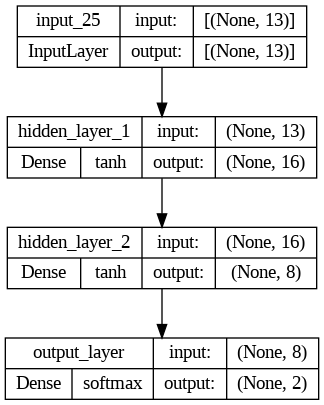

time: 287 ms (started: 2023-09-26 17:10:12 +00:00)


In [398]:
plot_model(small_model, show_shapes=True, show_layer_activations=True)

In [399]:
# params
verbosity = 0
epochs = 250

# define callbacks
reduce_lr_callback = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001,
    verbose=verbosity)

earlystopping = callbacks.EarlyStopping(
    monitor="val_loss", patience=50, restore_best_weights=True,
    min_delta=0.00001, start_from_epoch=50,
    verbose=verbosity)

# fit
small_fit  = small_model.fit(
    X_train_small_model,
    y_train_small_model,
    epochs=epochs,
    validation_data=(X_test_small_model, y_test_small_model),
    callbacks=[
        earlystopping,
        reduce_lr_callback],
    verbose=verbosity)
print()


time: 10.4 s (started: 2023-09-26 17:10:12 +00:00)


## Assessing the Model

In [400]:
small_fit_history = pd.DataFrame(small_fit.history)
model_architecture = f'{features.shape[1]} MFCCs & {hidden_layers} Hidden Layers'
print(f'Number of Actual Epochs: {small_fit_history.shape[0]}')

Number of Actual Epochs: 119
time: 1.78 ms (started: 2023-09-26 17:10:23 +00:00)


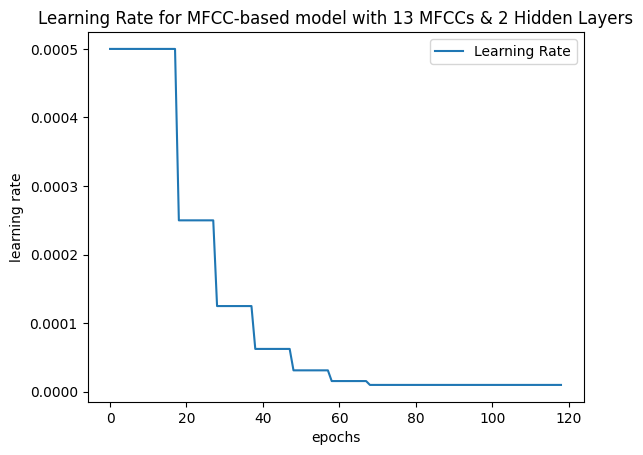

time: 1.61 s (started: 2023-09-26 17:10:23 +00:00)


In [401]:
learning_rate_history = small_fit_history[['lr']]
learning_rate_title = f'Learning Rate for MFCC-based model with {model_architecture}'
learning_rate_history = learning_rate_history.rename(
    columns={'lr': 'Learning Rate'})
learning_rate_history.plot(
    title=learning_rate_title, xlabel='epochs', ylabel='learning rate')
plt.show()

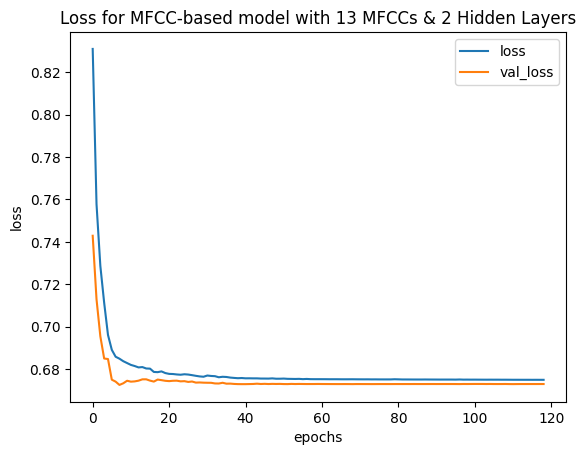

time: 431 ms (started: 2023-09-26 17:10:24 +00:00)


In [402]:
loss_history_title = f'Loss for MFCC-based model with {model_architecture}'
loss_history = small_fit_history[['loss','val_loss']]
loss_history.plot(title=loss_history_title, xlabel='epochs', ylabel='loss')
plt.show()

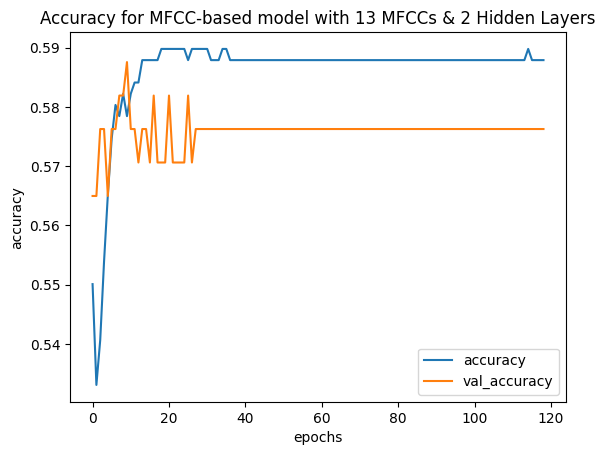

time: 398 ms (started: 2023-09-26 17:10:25 +00:00)


In [403]:
accuracy_history_title = f'Accuracy for MFCC-based model with {model_architecture}'
accuracy_history = small_fit_history[['accuracy','val_accuracy']]
accuracy_history.plot(
    title=accuracy_history_title, xlabel='epochs', ylabel='accuracy')
plt.show()

In [404]:
test_accuracy = small_model.evaluate(X_test_small_model, y_test_small_model,
  verbose=0)
print(test_accuracy)

[0.6728278398513794, 0.5762711763381958]
time: 125 ms (started: 2023-09-26 17:10:25 +00:00)


In [405]:
small_model_y_probability = small_model.predict(X_test_small_model, verbose=0)
small_model_y_predicted = np.argmax(small_model_y_probability, axis=-1)

time: 180 ms (started: 2023-09-26 17:10:25 +00:00)


In [406]:
# notice the y_test and not cat
small_model_report = metrics.classification_report(
    y_test_small_model, small_model_y_predicted, digits=4,
    target_names=['Non-Fatal','Fatal'])
print(small_model_report)

              precision    recall  f1-score   support

   Non-Fatal     0.3846    0.0694    0.1176        72
       Fatal     0.5915    0.9238    0.7212       105

    accuracy                         0.5763       177
   macro avg     0.4880    0.4966    0.4194       177
weighted avg     0.5073    0.5763    0.4757       177

time: 22.6 ms (started: 2023-09-26 17:10:26 +00:00)


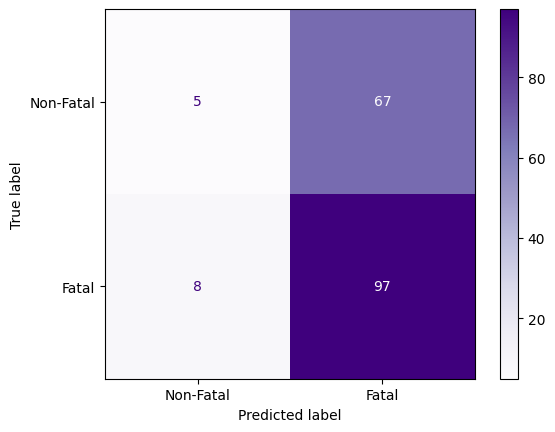

time: 331 ms (started: 2023-09-26 17:10:26 +00:00)


In [407]:
metrics.ConfusionMatrixDisplay.from_predictions(
    y_test_small_model, small_model_y_predicted,
    display_labels=['Non-Fatal','Fatal'],
    cmap='Purples')
plt.show()

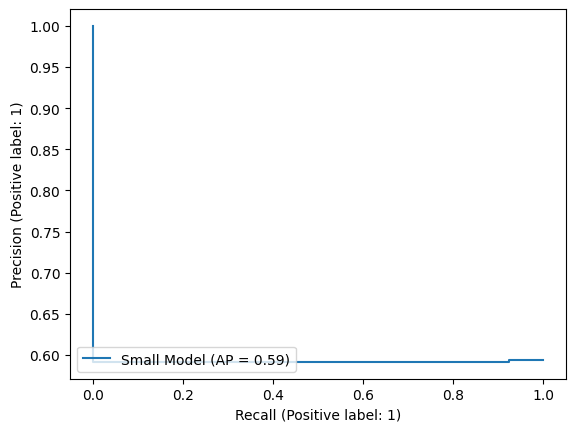

time: 374 ms (started: 2023-09-26 17:10:26 +00:00)


In [408]:
metrics.PrecisionRecallDisplay.from_predictions(
    y_test_small_model, small_model_y_predicted, name='Small Model')
plt.show()

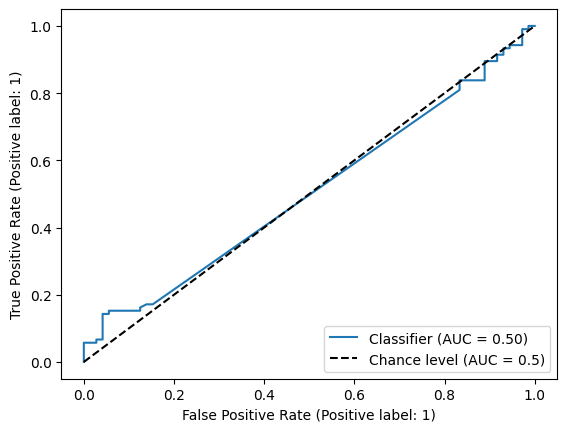

time: 321 ms (started: 2023-09-26 17:10:26 +00:00)


In [409]:
metrics.RocCurveDisplay.from_predictions(
    y_test_small_model, small_model_y_probability[:, 1], plot_chance_level=True)
plt.show()

# MFCC Model - Evened-out Classes

## Extracting Features and Classes

### Evening out the classes

In [312]:
print(features_classes['resulted_in_deaths'].value_counts())

1    418
0    288
Name: resulted_in_deaths, dtype: int64
time: 4.71 ms (started: 2023-09-26 16:57:27 +00:00)


In [313]:
# Create classification
num_of_non_death = features_classes['resulted_in_deaths'].value_counts()[0]
features_classes_even = features_classes.groupby('resulted_in_deaths', group_keys=False).apply(lambda x: x.sample(num_of_non_death))
features_classes_even = features_classes_even.sort_index()

features_classes_even.head(10)

,filename,features,resulted_in_deaths
0,911_first6sec/call_2_0.wav,"[-496.04065, 136.32658, -38.824547, -2.956653,...",1
1,911_first6sec/call_8_0.wav,"[-542.26483, 113.492096, -54.898445, -16.93544...",1
2,911_first6sec/call_9_0.wav,"[-469.10492, 144.50133, -53.16924, -35.66156, ...",0
3,911_first6sec/call_10_0.wav,"[-461.7921, 102.00011, 4.2778754, -3.2980382, ...",1
4,911_first6sec/call_11_0.wav,"[-388.4136, 191.76454, -68.483246, -28.393341,...",0
5,911_first6sec/call_12_0.wav,"[-366.632, 123.76255, -8.727576, -9.830455, 2....",1
6,911_first6sec/call_13_0.wav,"[-328.94275, 173.40773, -122.68931, -22.340195...",1
7,911_first6sec/call_15_0.wav,"[-388.2811, 92.171074, 0.91390646, -14.596169,...",1
9,911_first6sec/call_17_0.wav,"[-335.3681, 180.51752, -75.116455, -6.7831354,...",1
10,911_first6sec/call_18_0.wav,"[-406.30365, 171.65135, -23.042957, -5.772533,...",0


time: 19.2 ms (started: 2023-09-26 16:57:28 +00:00)


In [314]:
print(f'Dataframe Shape: {features_classes_even.shape}')

Dataframe Shape: (576, 3)
time: 2.2 ms (started: 2023-09-26 16:57:28 +00:00)


### Creating Trainging and Testing Sets

In [315]:
features_even = np.array(features_classes_even['features'].tolist())
classes_even = np.array(features_classes_even['resulted_in_deaths'])

time: 2.32 ms (started: 2023-09-26 16:57:28 +00:00)


In [316]:
print(classes_even.shape)

(576,)
time: 2.24 ms (started: 2023-09-26 16:57:28 +00:00)


In [317]:
print(features_even.shape)

(576, 13)
time: 580 µs (started: 2023-09-26 16:57:28 +00:00)


In [318]:
X_train_even_model, X_test_even_model, y_train_even_model, y_test_even_model = train_test_split(
    features_even, classes_even, test_size=0.25, shuffle=True,
    stratify=classes_even, random_state=0
    )

time: 4.49 ms (started: 2023-09-26 16:57:28 +00:00)


## Defining the Model and Training

In [358]:
input_shape = (features.shape[1],)
hidden_layers = 2
unit_scalar = 3

optimizer_name = 'Adam'
learning_rate = 0.0005

even_model = create_model(
    input_shape=input_shape, hidden_layers=hidden_layers,
    unit_scalar=unit_scalar, optimizer_name=optimizer_name,
    learning_rate=learning_rate)

print(even_model.summary())

Model: "model_2hl_13mfcc"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)      (None, 32)                448       
                                                                 
 hidden_layer_2 (Dense)      (None, 16)                528       
                                                                 
 output_layer (Dense)        (None, 2)                 34        
                                                                 
Total params: 1010 (3.95 KB)
Trainable params: 1010 (3.95 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
time: 139 ms (started: 2023-09-26 17:03:03 +00:00)


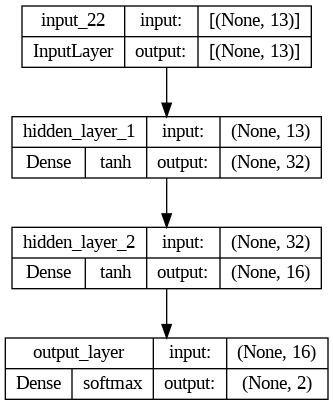

time: 98.4 ms (started: 2023-09-26 17:03:04 +00:00)


In [359]:
plot_model(even_model, show_shapes=True, show_layer_activations=True)

In [ ]:
# params
verbosity = 1
epochs = 250

# define callbacks
reduce_lr_callback = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=10, min_lr=0.000005,
    verbose=verbosity)

earlystopping = callbacks.EarlyStopping(
    monitor="val_loss", patience=50, restore_best_weights=True,
    min_delta=0.00001, start_from_epoch=50,
    verbose=verbosity)

# fit
even_fit = even_model.fit(
    X_train_even_model,
    y_train_even_model,
    epochs=epochs,
    validation_data=(X_test_even_model, y_test_even_model),
    callbacks=[
        earlystopping,
        reduce_lr_callback],
    verbose=verbosity)
print()

## Assessing the Model

In [361]:
even_fit_history = pd.DataFrame(even_fit.history)
model_architecture = f'{features.shape[1]} MFCCs & {hidden_layers} Hidden Layers'
print(f'Number of Actual Epochs: {even_fit_history.shape[0]}')

Number of Actual Epochs: 104
time: 4.98 ms (started: 2023-09-26 17:03:16 +00:00)


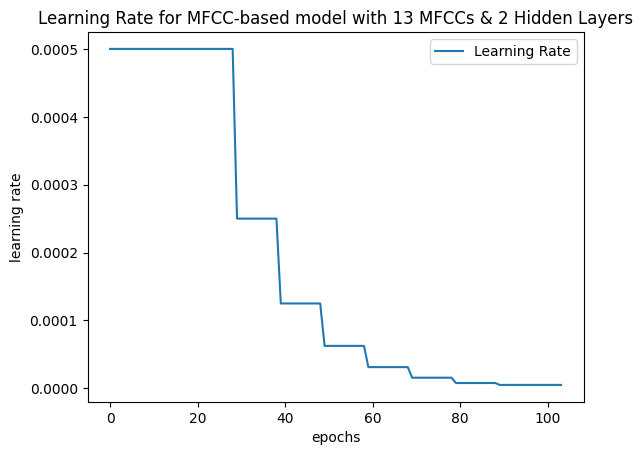

time: 10.2 s (started: 2023-09-26 17:03:16 +00:00)


In [362]:
learning_rate_history = even_fit_history[['lr']]
learning_rate_title = f'Learning Rate for MFCC-based model with {model_architecture}'
learning_rate_history = learning_rate_history.rename(
    columns={'lr': 'Learning Rate'})
learning_rate_history.plot(
    title=learning_rate_title, xlabel='epochs', ylabel='learning rate')
plt.show()

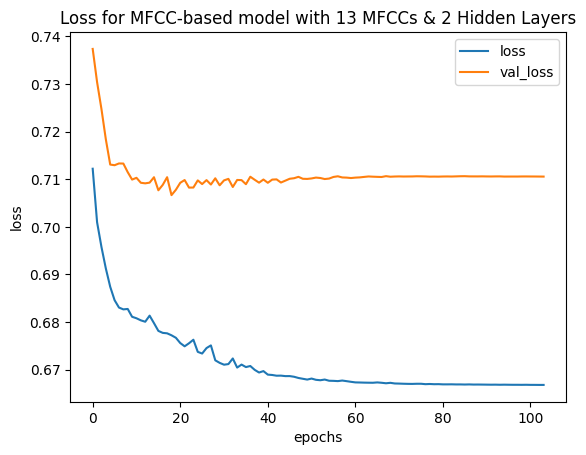

time: 444 ms (started: 2023-09-26 17:03:26 +00:00)


In [363]:
loss_history_title = f'Loss for MFCC-based model with {model_architecture}'
loss_history = even_fit_history[['loss','val_loss']]
loss_history.plot(title=loss_history_title, xlabel='epochs', ylabel='loss')
plt.show()

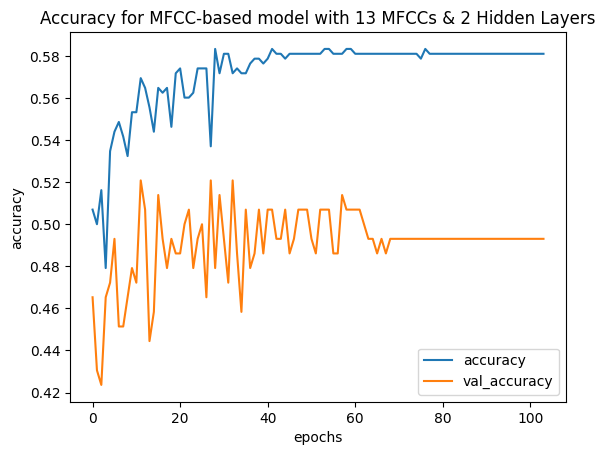

time: 443 ms (started: 2023-09-26 17:03:27 +00:00)


In [364]:
accuracy_history_title = f'Accuracy for MFCC-based model with {model_architecture}'
accuracy_history = even_fit_history[['accuracy','val_accuracy']]
accuracy_history.plot(
    title=accuracy_history_title, xlabel='epochs', ylabel='accuracy')
plt.show()

In [365]:
test_accuracy = even_model.evaluate(X_test_even_model, y_test_even_model,
  verbose=0)
print(test_accuracy)

[0.7100376486778259, 0.5069444179534912]
time: 149 ms (started: 2023-09-26 17:03:27 +00:00)


In [366]:
even_model_y_probability = even_model.predict(X_test_even_model, verbose=0)
even_model_y_predicted = np.argmax(even_model_y_probability, axis=-1)

time: 180 ms (started: 2023-09-26 17:03:27 +00:00)


In [367]:
# notice the y_test and not cat
even_model_report = metrics.classification_report(
    y_test_even_model, even_model_y_predicted, digits=4,
    target_names=['Non-Fatal','Fatal'])
print(even_model_report)

              precision    recall  f1-score   support

   Non-Fatal     0.5111    0.3194    0.3932        72
       Fatal     0.5051    0.6944    0.5848        72

    accuracy                         0.5069       144
   macro avg     0.5081    0.5069    0.4890       144
weighted avg     0.5081    0.5069    0.4890       144

time: 23.8 ms (started: 2023-09-26 17:03:27 +00:00)


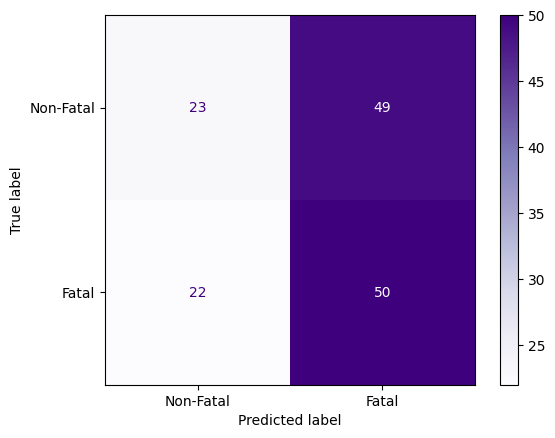

time: 367 ms (started: 2023-09-26 17:03:27 +00:00)


In [368]:
metrics.ConfusionMatrixDisplay.from_predictions(
    y_test_even_model, even_model_y_predicted,
    display_labels=['Non-Fatal','Fatal'],
    cmap='Purples')
plt.show()

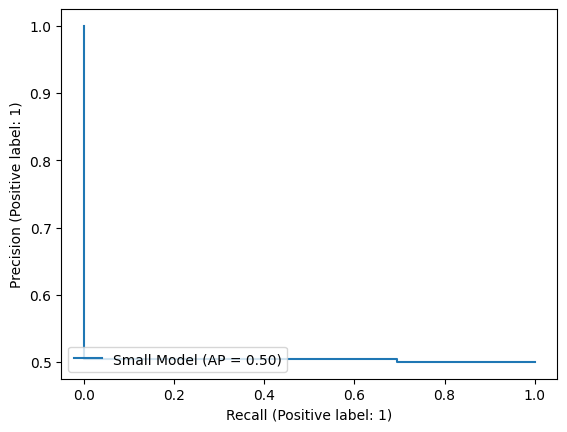

time: 339 ms (started: 2023-09-26 17:03:28 +00:00)


In [369]:
metrics.PrecisionRecallDisplay.from_predictions(
    y_test_even_model, even_model_y_predicted, name='Small Model')
plt.show()

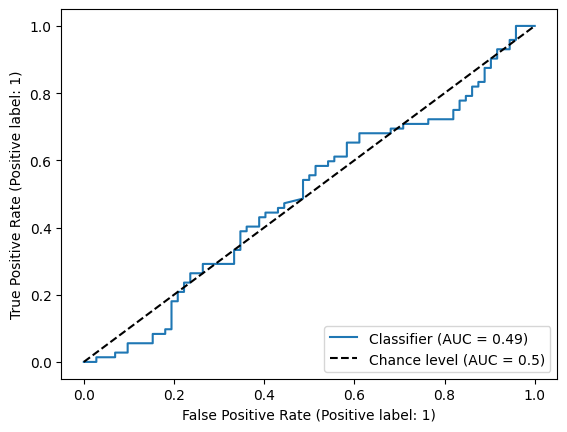

time: 373 ms (started: 2023-09-26 17:03:28 +00:00)


In [370]:
metrics.RocCurveDisplay.from_predictions(
    y_test_even_model, even_model_y_probability[:, 1], plot_chance_level=True)
plt.show()